#Setup & Imports

In [ ]:
from google.colab import drive
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import math
import glob
import shutil

drive.mount('/content/drive')

Mounted at /content/drive


#Paths & Hyperparameters

In [ ]:
BASE_PROJECT_DIR = "/content/drive/MyDrive/DeepLearnProject"

DATA_ROOT = os.path.join(BASE_PROJECT_DIR, "content")
PROCESSED_DIR = os.path.join(BASE_PROJECT_DIR, "processed_faces")
TEST_IMAGES_DIR = os.path.join(BASE_PROJECT_DIR, "test_images")

# Hyperparameters
INPUT_SIZE = (64, 64)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 20
EMBEDDING_DIM = 128
TRIPLET_MARGIN = 0.2
RECOGNITION_THRESHOLD = 0.5

# MTCNN

In [ ]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
print("✅ MTCNN detector initialized.")

✅ MTCNN detector initialized.


#Data Preprocessing

In [ ]:
def prepare_face_data_mtcnn():
    os.makedirs(PROCESSED_DIR, exist_ok=True)

    total_images_processed = 0
    total_faces_found = 0
    min_confidence = 0.9 #

    print(f"Starting MTCNN face detection (Min Confidence: {min_confidence})...")

    for person in os.listdir(DATA_ROOT):
        person_path = os.path.join(DATA_ROOT, person)
        if not os.path.isdir(person_path):
            continue

        save_dir = os.path.join(PROCESSED_DIR, person)
        os.makedirs(save_dir, exist_ok=True)

        print(f"Processing folder: {person}")
        person_image_count = 0
        person_face_count = 0

        for img_name in tqdm(os.listdir(person_path), desc=f"  -> {person}"):
            img_path = os.path.join(person_path, img_name)
            try:
                img_bgr = cv2.imread(img_path)
                if img_bgr is None: continue
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            except Exception as e:
                print(f"Error reading {img_name}: {e}")
                continue

            total_images_processed += 1
            person_image_count += 1
            faces = detector.detect_faces(img_rgb)

            if len(faces) > 0:
                high_conf_faces = [f['box'] for f in faces if f['confidence'] >= min_confidence]

                if high_conf_faces:
                    (x, y, w, h) = max(high_conf_faces, key=lambda rect: rect[2] * rect[3])
                    x, y = abs(x), abs(y)
                    face_crop = img_bgr[y:y+h, x:x+w]

                    if face_crop.size == 0: continue

                    face_resized = cv2.resize(face_crop, INPUT_SIZE)
                    save_path = os.path.join(save_dir, img_name)
                    cv2.imwrite(save_path, face_resized)

                    total_faces_found += 1
                    person_face_count += 1

        print(f"  -> Processed {person_image_count} images, found {person_face_count} faces.")

    print("\n✅ Face preparation complete (MTCNN).")
    print(f"Total images scanned: {total_images_processed}")
    print(f"Total faces extracted: {total_faces_found}")

prepare_face_data_mtcnn()

Starting MTCNN face detection (Min Confidence: 0.9)...
Processing folder: BraddPitt


  -> BraddPitt: 100%|██████████| 80/80 [00:12<00:00,  6.50it/s]


  -> Processed 80 images, found 80 faces.
Processing folder: AlexandraDaddario


  -> AlexandraDaddario: 100%|██████████| 80/80 [00:12<00:00,  6.44it/s]


  -> Processed 80 images, found 80 faces.
Processing folder: RobertDowneyJR


  -> RobertDowneyJR: 100%|██████████| 80/80 [00:12<00:00,  6.44it/s]


  -> Processed 80 images, found 79 faces.
Processing folder: BillieEliish


  -> BillieEliish: 100%|██████████| 80/80 [01:13<00:00,  1.09it/s]

  -> Processed 80 images, found 78 faces.

✅ Face preparation complete (MTCNN).
Total images scanned: 320
Total faces extracted: 317


#Model Definition

In [ ]:
class FaceRecogCNN(nn.Module):
    def __init__(self, embedding_dim):
        super(FaceRecogCNN, self).__init__()
        # Block 1: 64x64 -> 32x32
        self.conv1_1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv1_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)

        # Block 2: 32x32 -> 16x16
        self.conv2_1 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(64)

        # Block 3: 16x16 -> 8x8
        self.conv3_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(128)

        # FC layers
        # ขนาด Input = 128 (channels) * 8 * 8 (ขนาดภาพหลัง Pool 3 ครั้ง)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, embedding_dim)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = self.bn1(self.pool1(F.relu(self.conv1_2(x))))

        # Block 2
        x = F.relu(self.conv2_1(x))
        x = self.bn2(self.pool2(F.relu(self.conv2_2(x))))

        # Block 3
        x = F.relu(self.conv3_1(x))
        x = self.bn3(self.pool3(F.relu(self.conv3_2(x))))

        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        x = F.normalize(x, p=2, dim=1) # Normalize embedding
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FaceRecogCNN(EMBEDDING_DIM).to(device)
print(f"Model V2 (Deeper) loaded to {device}")

Model V2 (Deeper) loaded to cuda


#Transforms & Triplet Dataset

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),      # พลิกซ้ายขวา (ดี)
    transforms.RandomRotation(10),               # หมุนแค่ 10 องศา (พอประมาณ)
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # ปรับแสงสีเล็กน้อย
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_inf = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# 2. สร้าง TripletFaceDataset (รองรับ Subset)
class TripletFaceDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.full_dataset = self.subset.dataset
        self.all_labels = np.array(self.full_dataset.targets)
        self.indices = self.subset.indices
        self.labels = self.all_labels[self.indices]
        self.labels_set = set(self.labels)
        self.label_to_indices_map = {label: np.where(self.labels == label)[0]
                                     for label in self.labels_set}

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        anchor_label = self.labels[index]
        anchor_true_index = self.indices[index]
        anchor_img, _ = self.full_dataset[anchor_true_index]

        positive_subset_index = index
        while positive_subset_index == index:
            positive_subset_index = np.random.choice(self.label_to_indices_map[anchor_label])
        positive_true_index = self.indices[positive_subset_index]
        positive_img, _ = self.full_dataset[positive_true_index]

        possible_negative_labels = list(self.labels_set - {anchor_label})

        if not possible_negative_labels:
            negative_img = positive_img
        else:
            negative_label = np.random.choice(possible_negative_labels)
            negative_subset_index = np.random.choice(self.label_to_indices_map[negative_label])
            negative_true_index = self.indices[negative_subset_index]
            negative_img, _ = self.full_dataset[negative_true_index]

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img


# 3. สร้าง DataLoaders
full_image_dataset_for_triplet = datasets.ImageFolder(root=PROCESSED_DIR)
class_names = full_image_dataset_for_triplet.classes
print("Classes:", class_names)

train_size = int(0.8 * len(full_image_dataset_for_triplet))
val_size = len(full_image_dataset_for_triplet) - train_size
train_indices, val_indices = random_split(range(len(full_image_dataset_for_triplet)), [train_size, val_size])

train_subset = torch.utils.data.Subset(full_image_dataset_for_triplet, train_indices)
val_subset = torch.utils.data.Subset(full_image_dataset_for_triplet, val_indices)

train_triplet_dataset = TripletFaceDataset(train_subset, transform=transform_train)
val_triplet_dataset = TripletFaceDataset(val_subset, transform=transform_inf)

train_loader = DataLoader(train_triplet_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=BATCH_SIZE, shuffle=False)

gallery_image_dataset = datasets.ImageFolder(root=PROCESSED_DIR, transform=transform_inf)
gallery_loader = DataLoader(gallery_image_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_triplet_dataset)}")
print(f"Validation dataset size: {len(val_triplet_dataset)}")
print(f"Gallery dataset size: {len(gallery_image_dataset)}")

Classes: ['AlexandraDaddario', 'BillieEliish', 'BraddPitt', 'RobertDowneyJR']
Train dataset size: 253
Validation dataset size: 64
Gallery dataset size: 317


# Training Function (Triplet Loss)

Epoch 1/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s, Loss=0.0321]


Epoch [1/20] Train Loss: 0.0144 | Val Loss: 0.0321
  -> New best model saved to /content/drive/MyDrive/DeepLearnProject/face_siamese_model.pth (Val Loss: 0.0321)


Epoch 2/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.31it/s, Loss=0.0651]


Epoch [2/20] Train Loss: 0.0102 | Val Loss: 0.0651


Epoch 3/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.18it/s, Loss=0.0571]


Epoch [3/20] Train Loss: 0.0147 | Val Loss: 0.0571


Epoch 4/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.97it/s, Loss=0.0923]


Epoch [4/20] Train Loss: 0.0099 | Val Loss: 0.0923


Epoch 5/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.43it/s, Loss=0.0743]


Epoch [5/20] Train Loss: 0.0130 | Val Loss: 0.0743


Epoch 6/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.29it/s, Loss=0.0604]


Epoch [6/20] Train Loss: 0.0097 | Val Loss: 0.0604


Epoch 7/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, Loss=0.0512]


Epoch [7/20] Train Loss: 0.0109 | Val Loss: 0.0512


Epoch 8/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s, Loss=0.0487]


Epoch [8/20] Train Loss: 0.0116 | Val Loss: 0.0487


Epoch 9/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.20it/s, Loss=0.0919]


Epoch [9/20] Train Loss: 0.0133 | Val Loss: 0.0919


Epoch 10/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.62it/s, Loss=0.0918]


Epoch [10/20] Train Loss: 0.0061 | Val Loss: 0.0918


Epoch 11/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s, Loss=0.0838]


Epoch [11/20] Train Loss: 0.0204 | Val Loss: 0.0838


Epoch 12/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.35it/s, Loss=0.106]


Epoch [12/20] Train Loss: 0.0183 | Val Loss: 0.1056


Epoch 13/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.52it/s, Loss=0.0664]


Epoch [13/20] Train Loss: 0.0114 | Val Loss: 0.0664


Epoch 14/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.37it/s, Loss=0.0826]


Epoch [14/20] Train Loss: 0.0062 | Val Loss: 0.0826


Epoch 15/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.17it/s, Loss=0.0531]


Epoch [15/20] Train Loss: 0.0117 | Val Loss: 0.0531


Epoch 16/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.56it/s, Loss=0.0628]


Epoch [16/20] Train Loss: 0.0125 | Val Loss: 0.0628


Epoch 17/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s, Loss=0.0753]


Epoch [17/20] Train Loss: 0.0083 | Val Loss: 0.0753


Epoch 18/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, Loss=0.0601]


Epoch [18/20] Train Loss: 0.0155 | Val Loss: 0.0601


Epoch 19/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.38it/s, Loss=0.045]


Epoch [19/20] Train Loss: 0.0078 | Val Loss: 0.0450


Epoch 20/20 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.36it/s, Loss=0.0525]


Epoch [20/20] Train Loss: 0.0025 | Val Loss: 0.0525
✅ Training complete.


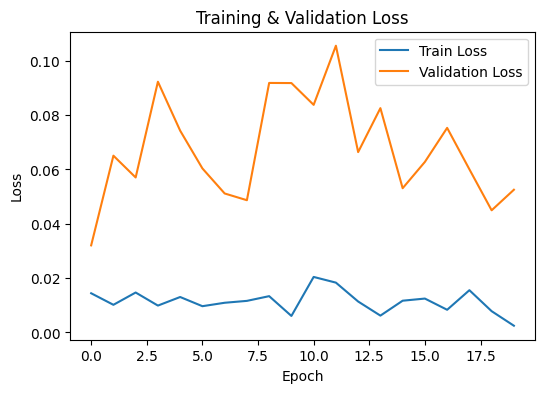

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, lr, margin):
    criterion = nn.TripletMarginLoss(margin=margin)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for anchor_img, positive_img, negative_img in train_loader_tqdm:
            anchor_img = anchor_img.to(device)
            positive_img = positive_img.to(device)
            negative_img = negative_img.to(device)

            optimizer.zero_grad()

            emb_a = model(anchor_img)
            emb_p = model(positive_img)
            emb_n = model(negative_img)

            loss = criterion(emb_a, emb_p, emb_n)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_loader_tqdm.set_postfix(Loss=running_loss/len(train_loader_tqdm))

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for anchor_img, positive_img, negative_img in val_loader_tqdm:
                anchor_img = anchor_img.to(device)
                positive_img = positive_img.to(device)
                negative_img = negative_img.to(device)

                emb_a = model(anchor_img)
                emb_p = model(positive_img)
                emb_n = model(negative_img)

                loss = criterion(emb_a, emb_p, emb_n)
                val_loss += loss.item()
                val_loader_tqdm.set_postfix(Loss=val_loss/len(val_loader_tqdm))

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # บันทึกโมเดลที่ดีที่สุด (วัดจาก Val Loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"  -> New best model saved to {MODEL_SAVE_PATH} (Val Loss: {val_loss:.4f})")


    print("✅ Training complete.")

    # Plot loss curve
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.savefig("triplet_loss_curve.png")
    plt.show()

    return model

# เริ่มเทรน
model = train_model(model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, TRIPLET_MARGIN)

# Create Embedding Gallery

In [ ]:
def create_embedding_gallery(model, data_loader, class_names):
    model.eval()
    embeddings = {}

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            embeds = model(images)

            for i in range(len(labels)):
                label_name = class_names[labels[i]]
                if label_name not in embeddings:
                    embeddings[label_name] = []
                embeddings[label_name].append(embeds[i])

    gallery = {}
    for label_name, embs_list in embeddings.items():
        gallery[label_name] = torch.mean(torch.stack(embs_list), dim=0)

    print(f"✅ Embedding gallery created for {list(gallery.keys())}")
    return gallery

# สร้าง Gallery
gallery = create_embedding_gallery(model, gallery_loader, class_names)

✅ Embedding gallery created for ['AlexandraDaddario', 'BillieEliish', 'BraddPitt', 'RobertDowneyJR']


#Inference Function (Recognition)

In [ ]:
def run_inference(image_path, model, gallery, transform_inf):
    model.eval()
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"❌ Image not found at {image_path}")
        return None

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    faces = detector.detect_faces(img_rgb)

    if len(faces) == 0:
        print(f"⚠️ No face detected in {os.path.basename(image_path)}.")
        return img_bgr

    print(f"Found {len(faces)} faces in {os.path.basename(image_path)}.")
    img_with_boxes = img_bgr.copy()

    for i, face in enumerate(faces):
        if face['confidence'] < 0.9:
            continue

        (x, y, w, h) = face['box']
        x, y = abs(x), abs(y)

        face_crop = img_bgr[y:y+h, x:x+w]
        if face_crop.size == 0: continue

        face_tensor = transform_inf(Image.fromarray(cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB))).unsqueeze(0).to(device)

        with torch.no_grad():
            test_emb = model(face_tensor)
            distances = []
            for person_name, person_emb in gallery.items():
                dist = F.pairwise_distance(test_emb, person_emb.unsqueeze(0))
                distances.append((person_name, dist.item()))

        distances.sort(key=lambda x: x[1])
        predicted_name = distances[0][0]
        min_dist = distances[0][1]

        if min_dist > RECOGNITION_THRESHOLD:
            display_name = "Unknown"
            color = (0, 0, 255)
        else:
            display_name = predicted_name
            color = (0, 255, 0)

        label = f"{display_name} (Dist: {min_dist:.2f})"

        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img_with_boxes, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        print(f"  -> Face {i+1}: Closest is {predicted_name} (Dist: {min_dist:.2f})")

    return img_with_boxes

# Testing with 1 image

--- Testing single image: /content/drive/MyDrive/DeepLearnProject/test_images/Test03.png ---
Found 2 faces in Test03.png.
  -> Face 1: Closest is RobertDowneyJR (Dist: 0.49)
  -> Face 2: Closest is AlexandraDaddario (Dist: 1.00)


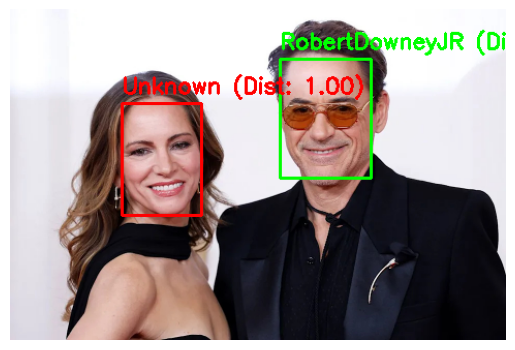

In [ ]:
os.makedirs(TEST_IMAGES_DIR, exist_ok=True)

TEST_IMAGE_PATH_SINGLE = os.path.join(TEST_IMAGES_DIR, "Test03.png") # ใส่ชื่อรูปที่ต้องการทดสอบ
print(f"--- Testing single image: {TEST_IMAGE_PATH_SINGLE} ---")

output_image = run_inference(TEST_IMAGE_PATH_SINGLE, model, gallery, transform_inf)

if output_image is not None:
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
else:
    print("Cannot display image (file not found or no face detected).")

# Testing with Multiple Images


--- Testing all images (Threshold: 0.5) ---
พบ 16 ภาพ, กำลังเริ่มทดสอบ...
Found 2 faces in Test01.jpg.
  -> Face 1: Closest is AlexandraDaddario (Dist: 1.05)
  -> Face 2: Closest is BraddPitt (Dist: 0.68)
Found 4 faces in Test02.png.
  -> Face 1: Closest is BillieEliish (Dist: 0.63)
  -> Face 2: Closest is BillieEliish (Dist: 0.81)
  -> Face 3: Closest is AlexandraDaddario (Dist: 0.51)
  -> Face 4: Closest is RobertDowneyJR (Dist: 0.37)
Found 2 faces in Test03.png.
  -> Face 1: Closest is RobertDowneyJR (Dist: 0.49)
  -> Face 2: Closest is AlexandraDaddario (Dist: 1.00)
Found 1 faces in Test04.png.
  -> Face 1: Closest is AlexandraDaddario (Dist: 0.21)
Found 1 faces in Test05.png.
  -> Face 1: Closest is BillieEliish (Dist: 0.79)
Found 2 faces in Test06.png.
  -> Face 1: Closest is BillieEliish (Dist: 0.54)
  -> Face 2: Closest is BillieEliish (Dist: 0.89)
Found 1 faces in Test07.png.
  -> Face 1: Closest is BillieEliish (Dist: 0.86)
Found 3 faces in Test08.png.
  -> Face 1: Closest i

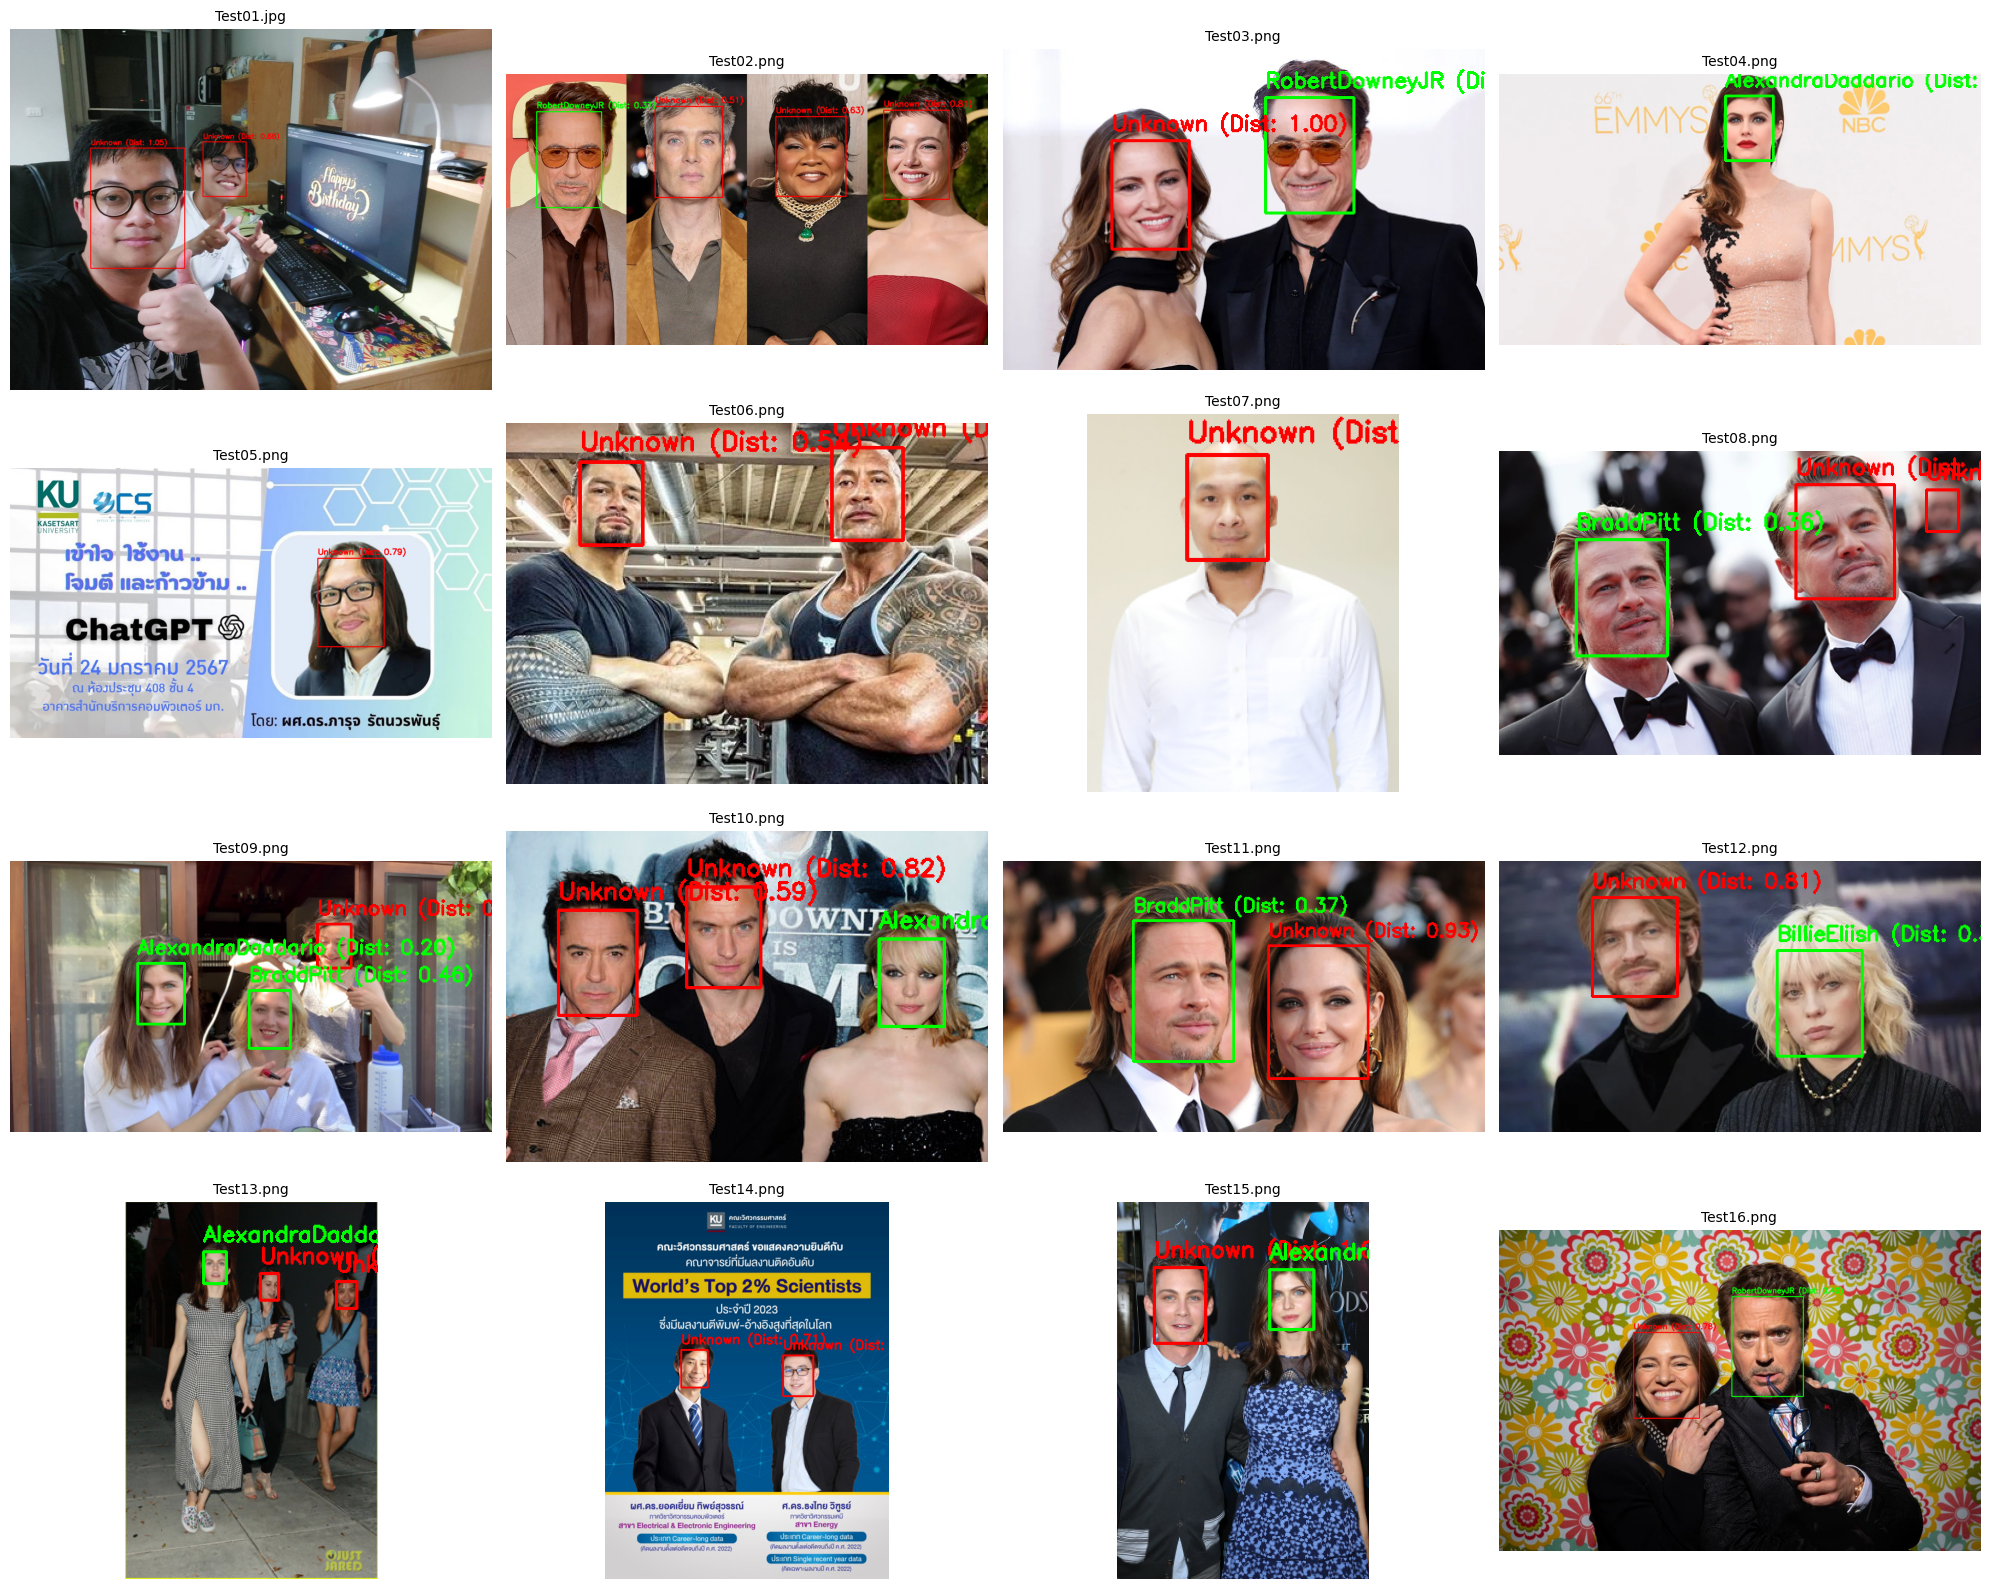

In [ ]:
def run_batch_inference(test_images_folder, model, gallery, transform_inf):
    image_paths = glob.glob(os.path.join(test_images_folder, '*.*'))
    image_paths = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_paths.sort()

    if not image_paths:
        print(f"None")
        return

    num_images = len(image_paths)
    print(f"พบ {num_images} ภาพ, กำลังเริ่มทดสอบ...")

    cols = 4
    rows = math.ceil(num_images / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, image_path in enumerate(image_paths):
        output_image_bgr = run_inference(image_path, model, gallery, transform_inf)

        if output_image_bgr is not None:
            img_rgb = cv2.cvtColor(output_image_bgr, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(os.path.basename(image_path), fontsize=10)

        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

print(f"\n--- Testing all images (Threshold: {RECOGNITION_THRESHOLD}) ---")
os.makedirs(TEST_IMAGES_DIR, exist_ok=True)
run_batch_inference(TEST_IMAGES_DIR, model, gallery, transform_inf)